# MACE in Practice I

In this tutorial, you will learn how to fit and test a `MACE` model, which is a highly accurate and efficient MLIP (Machine Learning Interatomic Potential). The training/testing techniques we show here, however, are broadly applicable to all MLIPs. You can independently learn about MACE by studying the [original method paper](https://proceedings.neurips.cc/paper_files/paper/2022/file/4a36c3c51af11ed9f34615b81edb5bbc-Paper-Conference.pdf). MACE was developed by unifying the Atomic Cluster Expansion (ACE) approach with the Neural Equivariant Interatomic Potentials (NequIP). The mathematical formalism which unifies these methods is explained in the [accompaning paper](https://doi.org/10.48550/arXiv.2205.06643). Another [useful reference](https://doi.org/10.48550/arXiv.2305.14247) showcases the method's performance on published benchmark datasets. The [code implementation](https://github.com/ACEsuit/mace) is publically available and [here](https://mace-docs.readthedocs.io/en/latest/) you can find the documentation. This notebook was made by Ioan Magdău and Ilyes Batatia and Will Baldwin.

### The goal of this notebook is to present all the steps to fitting a MACE potential, from understanding your data, to choosing the right hyper-parameters, testing the model and then running simulations.

## Learning Objectives for today:

1. **Understanding the data: diverse configs, reference labels**
2. **Understanding MACE parameters: architecture and training**
3. **Fitting and testing MACE models**
4. **Ultimate goal: stable and accurate Molecular Dynamics**

**In Colab, to activate the GPU, click on the top right on the down arrow next to Gemini, click on "Change runtime type" and select "T4 GPU" from the menu Hardware accelerator and save.
Then click on "Connect". If not working, change all "cuda" instances in the notebook to "cpu".**

In [1]:
# !git clone https://github.com/imagdau/Tutorials.git
# !pip install xtb nglview ipywidgets rdkit x3dase
# !pip install git+https://github.com/imagdau/aseMolec@main
# !pip install git+https://github.com/acesuit/mace@develop
# %cd Tutorials

## 1. Understanding the data

### 1.1 Diverse Molecular Conformations

Understanding the data is a crucial part of fitting an MLIP.
In this application, we will develop an MLIP for molecular liquids of carbonates. The data presented here is a subset from [this work](https://doi.org/10.1021/acs.jpcb.2c03746) and comprises a mixture of 6 different types of molecules: cyclic carbonates (Vinylene carbonate VC, Ethylene carbonate EC, Propylene carbonate PC) and linear carbonates (Dimethyl carbonate DMC, Ethyl Methyl Carbonate EMC, Diethyl carbonate DEC). Mixtures of these molecules in various formulations are used as solvents in Li-ion battery electrolytes.

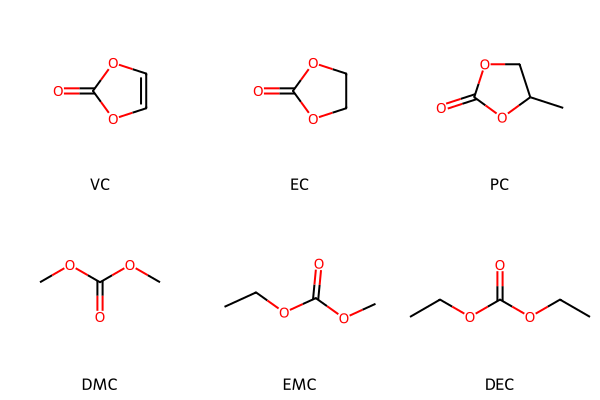

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw

# SMILES strings for each molecule
sm_dict = {
    'VC': 'c1coc(=O)o1',
    'EC': 'C1COC(=O)O1',
    'PC': 'CC1COC(=O)O1',
    'DMC': 'COC(=O)OC',
    'EMC': 'CCOC(=O)OC',
    'DEC': 'CCOC(=O)OCC'
}

Draw.MolsToGridImage([Chem.MolFromSmiles(sm_dict[mol]) for mol in sm_dict], legends=list(sm_dict.keys()))

For this tutorial, we prepared in advance a collection of atomic configurations (small subset from [this paper](https://doi.org/10.1021/acs.jpcb.2c03746)). Let's understand the data! We start by loading the raw configurations with no `labels` (energy, forces). The atomic `configurations`are stored in the [extxyz](https://wiki.fysik.dtu.dk/ase/ase/io/formatoptions.html#extxyz) format and can be accessed using [ASE](https://wiki.fysik.dtu.dk/ase/index.html) as shown below:

In [3]:
from ase.io import read, write
import numpy as np

db = read('data/solvent_configs.xyz', ':') #read in list of configs

print("Number of configs in database: ", len(db))
print("Number of atoms in each config: ", np.array([len(at) for at in db]))
print("Number of atoms in the smallest config: ", np.min([len(at) for at in db])) #test if database contains isolated atoms
print("Information stored in config.info: \n", db[10].info) #check info
print("Information stored in config.arrays: \n", db[10].arrays)

Number of configs in database:  5000
Number of atoms in each config:  [24 22 25 ... 25 32 40]
Number of atoms in the smallest config:  8
Information stored in config.info: 
 {}
Information stored in config.arrays: 
 {'numbers': array([6, 8, 6, 8, 6, 1, 1, 8, 1, 1, 6, 8, 8, 8, 6, 6, 6, 1, 1, 6, 1, 1,
       1, 1, 1, 1, 1, 1]), 'positions': array([[ 2.42930269,  5.21925545, -2.44555688],
       [ 1.36888075,  4.36736107, -3.07848001],
       [ 1.0430907 ,  3.33270121, -2.205446  ],
       [ 1.83499873,  3.2705152 , -1.20140588],
       [ 2.83662271,  4.2916441 , -1.29654086],
       [ 3.20092463,  5.52685308, -3.12019396],
       [ 1.98896468,  6.07220507, -2.07261896],
       [ 0.15712669,  2.55914021, -2.58440089],
       [ 3.80655074,  3.73805737, -1.62337792],
       [ 3.03487277,  4.82053137, -0.40139091],
       [-1.35643137, -2.96665978,  1.35700715],
       [-1.21188033, -2.7462728 ,  0.1501831 ],
       [-0.54117233, -3.68505168,  2.08627701],
       [-2.42475724, -2.65949082,  

At this point, each configuration is a collection of atoms: atomic number (Z) and positions (R), with no additional information. Let's identify the molecules and label molecular clusters. This will make it easier to inspect the data set and, later, test the accuracy of the potential on describing inter-molecular interactions. Molecule identification is achieved using the `wrap_molecs` function from the [aseMolec package](https://github.com/imagdau/aseMolec), shown here for the first 100 frames `db[:100]`.

In [4]:
from aseMolec import anaAtoms as aa

aa.wrap_molecs(db, prog=False) #identify molecules and label molecular clusters, showcase: first 100 frames
write('data/solvent_molecs.xyz', db) #save full result
print("Information stored in config.info: \n", db[10].info)
print("Information stored in config.arrays: \n", db[10].arrays)

Information stored in config.info: 
 {'Nmols': 2, 'Comp': 'DEC(1):EC(1)'}
Information stored in config.arrays: 
 {'numbers': array([6, 8, 6, 8, 6, 1, 1, 8, 1, 1, 6, 8, 8, 8, 6, 6, 6, 1, 1, 6, 1, 1,
       1, 1, 1, 1, 1, 1]), 'positions': array([[ 2.42930269,  5.21925545, -2.44555688],
       [ 1.36888075,  4.36736107, -3.07848001],
       [ 1.0430907 ,  3.33270121, -2.205446  ],
       [ 1.83499873,  3.2705152 , -1.20140588],
       [ 2.83662271,  4.2916441 , -1.29654086],
       [ 3.20092463,  5.52685308, -3.12019396],
       [ 1.98896468,  6.07220507, -2.07261896],
       [ 0.15712669,  2.55914021, -2.58440089],
       [ 3.80655074,  3.73805737, -1.62337792],
       [ 3.03487277,  4.82053137, -0.40139091],
       [-1.35643137, -2.96665978,  1.35700715],
       [-1.21188033, -2.7462728 ,  0.1501831 ],
       [-0.54117233, -3.68505168,  2.08627701],
       [-2.42475724, -2.65949082,  2.02500916],
       [ 0.77742571, -4.09808683,  1.66831815],
       [-3.53945827, -1.88707876,  1.42200

Note the additional information for each atomic config: number of molecules `Nmols`, molecular composition `Comp` (e.g `DEC(1):EC(1)` means the config comprises a dimer with 1 DEC molecule and 1 EC molecule) and molecular ID `molID`. Running the code for the full 5000 configurations can be slow, let's just load the final result (`data/solvent_molecs.xyz`) and inspect the distribution of configs by number of molecules:

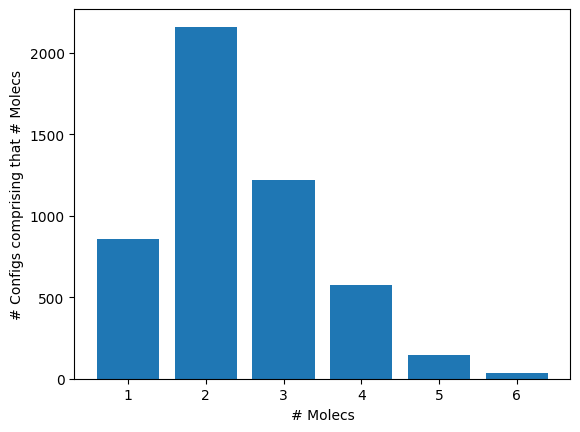

In [10]:
from matplotlib import pyplot as plt

db = read('data/solvent_molecs.xyz', ':')
Nmols = np.array([at.info['Nmols'] for at in db]) #collect Nmols information across all data
plt.hist(Nmols, align='left', bins=[1,2,3,4,5,6,7], rwidth=0.8);
plt.xlabel('# Molecs');
plt.ylabel('# Configs comprising that # Molecs');

There are just under 1000 configs comprising of single molecules and more than 2000 dimers. The largest configs contain clusters of six molecules.

We can check the distribution of molecular compositions for each cluster size:

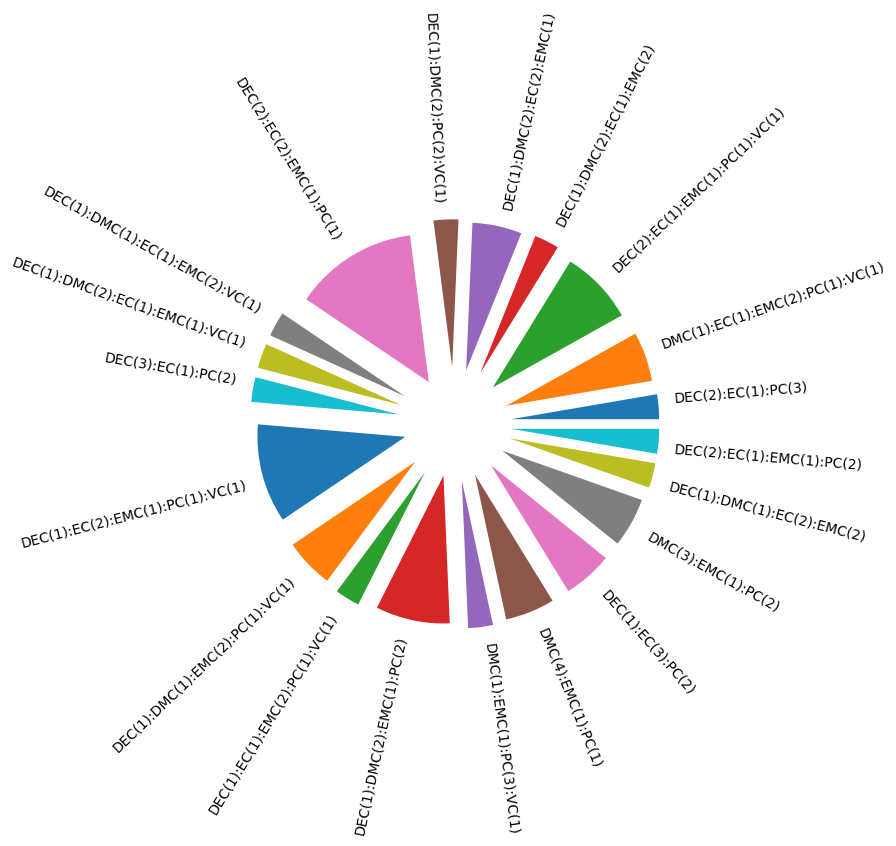

In [11]:
from aseMolec import extAtoms as ea
from collections import Counter

comp_dict = {} #create a dictionary of compositions for each cluster size
for Nmol in range(1,7):
    comp_dict[Nmol] = dict(Counter([at.info['Comp'] for at in ea.sel_by_info_val(db, 'Nmols', Nmol)]))

Nmol = 6 #show distribution of compositions for cluster size 6
plt.pie(comp_dict[Nmol].values(),
        labels=comp_dict[Nmol].keys(),
        explode=10/(25+np.array(list(comp_dict[Nmol].values()))),
        rotatelabels =True);

The training set is quite diverse and it contains a good mix of compositions. Check the distribution for other cluster sizes: `Nmol = 1, 2, 3, 4, 5`. Find out if all isolated molecules are present and well sampled. We have six molecules, so there should be 6x7/2 dimers present, are all dimers sampled?

### 1.2 Labeling Data with XTB Values

We convinced ourselves the training set is quite diverse, it samples many compositions and molecular cluster sizes. It is time to prepare the reference data (energies, forces) to train the model on. We will do this using the Semiempirical Tight Binding level of theory with [XTB](https://xtb-docs.readthedocs.io/en/latest/contents.html). Usually, we would here evaluate an expensive **DFT or quantum chemistry methods**. XTB is much less accurate than these methods for these systems, but it is fast and it will serve as a good example.

#### Isolated atoms energies
Notice the data set contains isolated molecules but no isolated atoms. MACE (and other MLIPs) fit to atomization energies (eV) which is total energy minus the energy of each atom in vacuum $(E^{0})$:
$$
E^{\rm atm} = E^{\rm tot}-\sum_i^{N} E^{0}
$$
It is essential that you compute the energies of the isolated atoms with your reference method on top of the dataset.
If you are using a dataset from the internet without that information, we will explain later how MACE can estimate these energies.

In our specific example, all molecules comprise of three chemical elements and we will need to compute $(E^{0})$ for each of them:

$$
E^{\rm atm} = E^{\rm tot}-\sum_i^{N_H} E^{H}_i-\sum_i^{N_C} E^{C}_i-\sum_i^{N_O} E^{O}_i
$$

Let us add three frames containing Hydrogen H, Carbon C and Oxygen O to the dataset and label them as `config_type=IsolatedAtom`

In [12]:
from ase import Atoms

db = read('data/solvent_molecs.xyz', ':')
db = [Atoms('H'), Atoms('C'), Atoms('O')]+db #add isolated atoms to the database

for at in db[:3]:
    at.info['config_type'] = 'IsolatedAtom'

print("Number of configs in database: ", len(db))

Number of configs in database:  5003


We are now ready to compute the energy and forces with XTB (usually you would run DFT at the stage):

In [13]:
from tqdm import tqdm
from xtb.ase.calculator import XTB
xtb_calc = XTB(method="GFN2-xTB")

for at in tqdm(db[:15]): #showcase: first 15 frames
    at.calc = xtb_calc
    at.info['energy_xtb'] = at.get_potential_energy()
    at.arrays['forces_xtb'] = at.get_forces()
# write('data/solvent_xtb.xyz', db) #save full result

print("Information stored in config.info: \n", db[13].info) #check info
print("Information stored in config.arrays: \n", db[13].arrays)

100%|██████████| 15/15 [00:00<00:00, 29.06it/s]

Information stored in config.info: 
 {'Nmols': 2, 'Comp': 'DEC(1):EC(1)', 'energy_xtb': -1323.8105075135988}
Information stored in config.arrays: 
 {'numbers': array([6, 8, 6, 8, 6, 1, 1, 8, 1, 1, 6, 8, 8, 8, 6, 6, 6, 1, 1, 6, 1, 1,
       1, 1, 1, 1, 1, 1]), 'positions': array([[ 2.42930269,  5.21925545, -2.44555688],
       [ 1.36888075,  4.36736107, -3.07848001],
       [ 1.0430907 ,  3.33270121, -2.205446  ],
       [ 1.83499873,  3.2705152 , -1.20140588],
       [ 2.83662271,  4.2916441 , -1.29654086],
       [ 3.20092463,  5.52685308, -3.12019396],
       [ 1.98896468,  6.07220507, -2.07261896],
       [ 0.15712669,  2.55914021, -2.58440089],
       [ 3.80655074,  3.73805737, -1.62337792],
       [ 3.03487277,  4.82053137, -0.40139091],
       [-1.35643137, -2.96665978,  1.35700715],
       [-1.21188033, -2.7462728 ,  0.1501831 ],
       [-0.54117233, -3.68505168,  2.08627701],
       [-2.42475724, -2.65949082,  2.02500916],
       [ 0.77742571, -4.09808683,  1.66831815],
       

The updated data contains one energy value for each config `energy_xtb` and the `forces_xtb` on each atom. Latest version of [ASE](https://wiki.fysik.dtu.dk/ase/index.html) does not support simple names such as `energy` and `forces` so we append `_xtb`. The entire computation takes about `25 mins` for the 5003 configs. We have precomputed the data, so we can simply load the final result. Let's check the $E^0$ values and atomization energies:

In [14]:
db = read('data/solvent_xtb.xyz', ':15')

print("E0s: \n", ea.get_E0(db, tag='_xtb'))
print("Total energy per config: \n", ea.get_prop(db, 'info', 'energy_xtb', peratom=False)[13])
print("Toal energy per atom: \n", ea.get_prop(db, 'info', 'energy_xtb', peratom=True)[13])
print("Atomization energy per config: \n", ea.get_prop(db, 'bind', prop='_xtb', peratom=False)[13])
print("Atomization energy per atom: \n", ea.get_prop(db, 'bind', prop='_xtb', peratom=True)[13])

E0s: 
 {'H': -10.707211383396714, 'C': -48.847445262804705, 'O': -102.57117256025786}
Total energy per config: 
 -1323.8105075135763
Toal energy per atom: 
 -47.278946696913444
Atomization energy per config: 
 -167.70295068203745
Atomization energy per atom: 
 -5.9893910957870515


Good! We get about -6 $\rm eV/atom$ which is largely dominated by the energy of the [covalent bonds](https://en.wikipedia.org/wiki/Bond-dissociation_energy#:~:text=of%20a%20solvent.-,Representative%20bond%20enthalpies,-%5Bedit%5D). Remember, the largest contribution to the total energy comes from $E^0$ and then from covalent bonds. The noncovalent interactions contribute a very small amount to the total energy, yet they are crucial for molecular dynamics.

## 2. Understanding MACE hyper parameters and interface

In order to train a MACE potential, one needs to create a configuration file that specifies three kind of information:
 1. Choice your model hyper-parameters.
 2. Specification of the data.
 3. Selection of your optimization parameters.

These informations are required in order to call the mace training script called `mace_run_train`.

The following section will cover in detail all of these three steps.

### 2.1 Model parameters

MACE has different hyper parameters that controls the degree of accuracy and expressivity of the model. Setting these parameters is a trade off between accuracy and computational cost. Most MACE parameters have robust and well tested defaults. We call them here "Parameters to keep to default values" but mention them for general knowledge. The "Hyper Parameters to Change" are hyper parameters that need to be adjusted as they can be task or system dependent.

### Hyper Parameters to Change:

- **`--num_channels`: Number of channels**
  
  Determines the size of the model. The recommended value is `--num_channels=128` but other potential values are `64` for a faster model or `256` for a large but more accurate model.
  
  
- **`max_L`: Symmetry of the messages**

  Determines the symmetry of the messages. A value of `--max_L=0` means MACE will pass only invariant information between neigborhoods. It is the parameter **that affects the most the computational speed and the accuracy of the model**. `--max_L=0` are the fastest model, use them to train cheap model to run large and long simulations. `--max_L=1` is the default value, it is a good compromise between speed and accuracy. It is recommended to start with that value for a new project. `--max_L=2` are the most accurate models, use them to train very accurate but slower models.
  

- **`--r_max`: The cutoff radius**
  
  The cutoff used to create the local environment in each layer. `r_max=5.0` means atoms separated by a distance of more than 5.0 Å do not directly communicate in a single layer. When the model has multiple message-passing layers, atoms further than 5.0 Å can still communicate through later messages if intermediate proxy atoms exist. The effective receptive field of the model is `num_interactions * r_max`. The larger the `r_max`, the slower the model will be. It is recommended to use values between 4.0 Å and 7.0 Å.

---

### Hyper Parameters to keep to default values (for general knowledge):

- **`--num_interactions`: Message-passing layers**
  
  Controls the number of message-passing layers in the model. It should always be 2, and it is recommended not to modify it.


- **`--correlation`: The order of the many-body expansion**

  The body order that MACE induces at each layer. Choosing `--correlation=3` will create basis functions of up to 4-body (ijkl) indices, for each layer. If the model has multiple layers, the effective correlation order is higher. For example, a two-layer MACE with `--correlation=3` has an effective body order of 13.


- **`--max_ell`: Angular resolution**

  The angular resolution describes how well the model can describe angles. This is controlled by `max_ell` of the spherical harmonics basis (not to be confused with `max_L`). Larger values will result in more accurate but slower models. The default is `max_ell=3`, which is appropriate in most cases.


### 2.2 Optimization and data management parameters

### General training management:


- ##### `--name`: the name of the model
    This name will be used to form file names (model, log, checkpoints, results), so choose a distinct name for each experiment

- ##### `--model_dir, --log_dir, --checkpoints_dir, --results_dir`: directory paths
    These are the directories where each type of file is saved. For simplicity, we will save all files in the same directory.

### Data management:

- ##### `--train_file`: name of training dataset

    These are the configurations that will be use to train the model.

- ##### `--valid_file`: name of validation dataset
    An alternative way to choose the validation set is by using the `--valid_fraction` keyword. These data configs are used to estimate the model accuracy during training, but not for parameter optimization. The validation set also controls the stopping of the training. At each `--eval_interval` the model is tested on the validation set. The evaluation of these configs takes place in batches, which can be controlled by `--valid_batch_size`. If the accuracy of the model stops improving on the validation set for `--patience` number of epochs, the model will undergo **early stopping**.

- ##### `--test_file`: name of testing dataset

    This set is entirely independent and only gets evaluated at the end of the training process to estimate the model accuracy on an independent set.

- ##### `--E0s`: isolated atom energies

    Controls how `E0s` should be determined. The strongly recommended approach is to add these values to the training set with `config_type=IsolatedAtom` in `atoms.info` and set `E0s="isolated"`. If these values are not available, MACE can estimate them by least square regression over the available data `E0s="average"` which can lead to unintended consequences depending on how representative the data is.

- ##### `--energy_key, --forces_key` the key where these values are stores
    This key must coincide with the `ase.Atoms.info[key]/ase.Atoms.arrays[key]` where the energies and forces are stored in the ase.Atoms object. **It is very important to get them right**.

### Optimization:

- ##### `--device` computing device to use
    Can be CPU (`cpu`), GPU (`cuda`) or Apple Silicon (`mps`). Here we will use `cuda` since the GPU will be significantly faster than the CPU.

- ##### `--batch_size` number of configs evaluated in one batch
    Number of configs used to compute the gradients for each full update of the network parameters. This training strategy is called stochastic gradient descent because only a subset of the data (`batch_size`) is used to change the parameters at each update.

- ##### `--max_num_epochs` number of passes through the data
    An `epoch` is completed when the entire training data has been used once in updating the weights `batch` by `batch`. A new epoch begins, and the process repeats.

- ##### `--swa` protocol for loss weights
    During training you will notice energy errors are at first much higher than force errors, MACE implements a special protocol that increases the weight on the energy in the loss function (`--swa_energy_weight`) once the forces are sufficiently accurate. The starting epoch for this special protocol can be controlled by changing `--start_swa`.

- ##### `--seed` random number generator seed
    Useful for preparing committee of models.

**Now we are ready to fit our first MACE model!**

## 3. Fitting and Testing MACE models

**Let's fit our first MACE model to our data.**

Let's start by splitting the data into a train and test set.

In [15]:
from ase.io import read, write

db = read('data/solvent_xtb.xyz', ':')
write('data/solvent_xtb_train_200.xyz', db[:203]) #first 200 configs plus the 3 E0s
write('data/solvent_xtb_test.xyz', db[-1000:]) #last 1000 configs

### 3.1 Fitting the model

We will now write our first configuration file, that contains all the information detailed above. This a template you can adapt to your own data later on. We will create a small invariant model in order to run fast in the limited time we have. **Try to understand each of the entries by looking at their explanations above**.

In [16]:
%%writefile config/config-02.yml

model: "MACE"
num_channels: 32
max_L: 0
r_max: 4.0
name: "mace01"
model_dir: "MACE_models"
log_dir: "MACE_models"
checkpoints_dir: "MACE_models"
results_dir: "MACE_models"
train_file: "data/solvent_xtb_train_200.xyz"
valid_fraction: 0.10
test_file: "data/solvent_xtb_test.xyz"
energy_key: "energy_xtb"
forces_key: "forces_xtb"
device: cuda
batch_size: 10
max_num_epochs: 100
swa: True
seed: 123


Overwriting config/config-02.yml


Normally you would call a script from the command line called `mace_run_train` (see https://mace-docs.readthedocs.io/en/latest/guide/training.html) and pass it a yaml file of parameters. Below we define a function to train mace from inside python instead.

In [17]:
import warnings
warnings.filterwarnings("ignore")
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging

def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ["program", "--config", config_file_path]
    mace_run_train_main()

In [18]:
train_mace("config/config-02.yml")

2024-10-08 11:24:53.192 INFO: ===========VERIFYING SETTINGS===========
2024-10-08 11:24:53.194 INFO: MACE version: 0.3.7
2024-10-08 11:24:53.256 INFO: CUDA version: 12.1, CUDA device: 0
2024-10-08 11:24:53.421 INFO: ===========LOADING INPUT DATA===========
2024-10-08 11:24:53.423 INFO: Using heads: ['default']
2024-10-08 11:24:53.424 INFO: =============    Processing head default     ===========
2024-10-08 11:24:53.676 INFO: Using isolated atom energies from training file
2024-10-08 11:24:53.681 INFO: Training set [200 configs, 200 energy, 17418 forces] loaded from 'data/solvent_xtb_train_200.xyz'
2024-10-08 11:24:53.688 INFO: Using random 10% of training set for validation with indices saved in: ./valid_indices_123.txt
2024-10-08 11:24:53.690 INFO: Validaton set contains 20 configurations [20 energy, 1977 forces]
2024-10-08 11:24:54.950 INFO: Test set (1000 configs) loaded from 'data/solvent_xtb_test.xyz':
2024-10-08 11:24:54.954 INFO: Default_Default: 1000 configs, 1000 energy, 90228

***Congratulations you have trained your first MACE model!!!***
**Extra: you can try to run new training by changing the model sizes and look at how it affects the accuracy in the final table**

In [19]:
#remove checkpoints since they may cause errors on retraining a model with the same name but a different architecture
import glob
import os
for file in glob.glob("MACE_models/*.pt"):
    os.remove(file)

##### **Question: Here we trained on a very small subset of the data, repeat training for 400, 1000, 2000, 4000 data points, remember to change the name of the model accordingly. How does the learning curve (test error vs size of training test) look like?** `

### 3.2 Testing the model: simple RMSEs

Use the `mace_eval_configs` script to evaluate the trained model on both the train and test datasets. The script takes the arguments: `--configs` which specifies the file to evaluate, the path to the model in `--model` and the path to the output in `--output`. Here we call it from python again.

In [20]:
import warnings
warnings.filterwarnings("ignore")

os.makedirs("tests/mace01/", exist_ok=True)

In [21]:
from mace.cli.eval_configs import main as mace_eval_configs_main
import sys

def eval_mace(configs, model, output):
    sys.argv = ["program", "--configs", configs, "--model", model, "--output", output]
    mace_eval_configs_main()

In [22]:
#evaluate the training set
eval_mace(configs="data/solvent_xtb_train_200.xyz",
          model="MACE_models/mace01_run-123_stagetwo.model",
          output="tests/mace01/solvent_train.xyz")

#evaluate the test set
eval_mace(configs="data/solvent_xtb_test.xyz",
          model="MACE_models/mace01_run-123_stagetwo.model",
          output="tests/mace01/solvent_test.xyz")

2024-10-08 11:29:25.145 INFO: Using CPU
2024-10-08 11:29:29.351 INFO: Using CPU


We can compare MACE vs XTB accuracy on the train and test sets and for this we will use the [aseMolec](git@github.com:imagdau/aseMolec.git) which implements some handy utilities for manipulating ase.Atoms and testing potentials, especially for molecular systems.

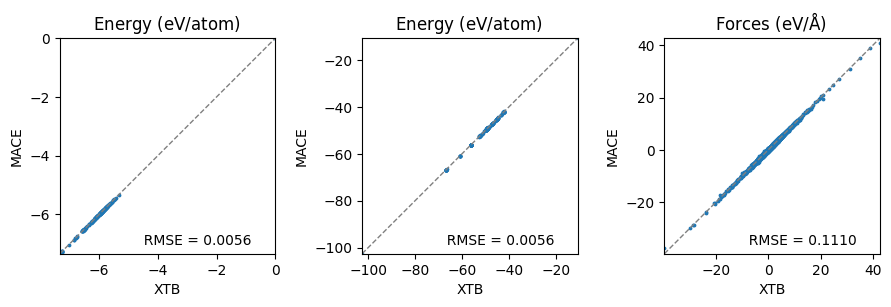

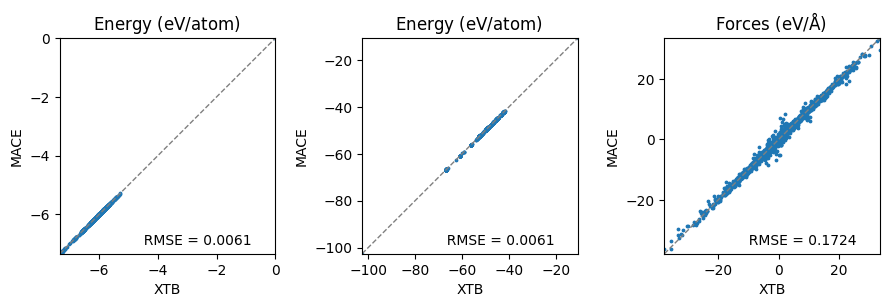

In [23]:
from aseMolec import pltProps as pp
from ase.io import read
import matplotlib.pyplot as plt
from aseMolec import extAtoms as ea
import numpy as np

def plot_RMSEs(db, labs):
    ea.rename_prop_tag(db, 'MACE_energy', 'energy_mace') #Backward compatibility
    ea.rename_prop_tag(db, 'MACE_forces', 'forces_mace') #Backward compatibility

    plt.figure(figsize=(9,6), dpi=100)
    plt.subplot(1,3,1)
    pp.plot_prop(ea.get_prop(db, 'bind', '_xtb', True).flatten(), \
                 ea.get_prop(db, 'bind', '_mace', True).flatten(), \
                 title=r'Energy $(\rm eV/atom)$ ', labs=labs, rel=False)
    plt.subplot(1,3,2)
    pp.plot_prop(ea.get_prop(db, 'info', 'energy_xtb', True).flatten(), \
                 ea.get_prop(db, 'info', 'energy_mace', True).flatten(), \
                 title=r'Energy $(\rm eV/atom)$ ', labs=labs, rel=False)
    plt.subplot(1,3,3)
    pp.plot_prop(np.concatenate(ea.get_prop(db, 'arrays', 'forces_xtb')).flatten(), \
                 np.concatenate(ea.get_prop(db, 'arrays', 'forces_mace')).flatten(), \
                 title=r'Forces $\rm (eV/\AA)$ ', labs=labs, rel=False)
    plt.tight_layout()
    return

train_data = read('tests/mace01/solvent_train.xyz', ':')
test_data = train_data[:3]+read('tests/mace01/solvent_test.xyz', ':') #append the E0s for computing atomization energy errors

plot_RMSEs(train_data, labs=['XTB', 'MACE'])
plot_RMSEs(test_data, labs=['XTB', 'MACE'])

These figures show correlation plots between XTB values and MACE predicted values for atomization energy per atom, the total energy per atom and forces. Do the RMSE values match the number printed at the end of the model training? These errors don't look too bad, and this MACE is a small model with few parameters. Significantly better accuracies can be achieved when training on larger models with more data. How does your model trained on 4000 configs compare?

### 3.3 Testing on the Intra/Inter decomposition:

As shown in this [paper](https://doi.org/10.1038/s41524-023-01100-w) one of the challenges associated with modelling molecular systems has to do with the  inter-molecular interactions.
Molecular dynamics is primarily driven by these inter-molecular interactions, however they are relatively small in comparison to covalent interactions and prove difficult to capture with MLIPs.
The paper introduces this protocol to decompose the force errors into [intra- and inter-] molecular RMSEs to gauge the quality of the potential separately on the two interaction scales. This approach can be summarized as follows:
1. Identify molecules (labeled **j**).  

2. Within each molecule **j** sum over all atomic forces (labeled **k**) to obtain the **translational** component:
$$F^{\rm trans}_j = \sum_{k \in j} f_{k}$$

3. Redistribute the molecular **translational** force onto individual atoms (labeled **i**) to obtain the atomic **translational** contributions:
$$f^{\rm trans}_i = \frac{m_i}{M_j} F^{\rm trans}_j$$

4. Similarly, compute the torque on the entire molecule:
$$T_j = \sum_{k \in j} f_{k} \times r_{k}$$

5. Compute the atomic **rotational** force contributions that give rise to the given molecular torque:
$$f^{\rm rot}_i = m_i r_i \times (I_j^{\alpha \beta})^{-1} T_j$$

6. Finally compute the **vibrational** contribution as the difference:
$$f^{\rm vib}_i = f_i - f^{\rm trans}_i - f^{\rm rot}_i$$

7. In this approach, the **Inter** is the sum of `trans` and `rot`, while the **Intra** is the `vib` component.

This force decomposition can be automatically obtained using the [aseMolec](https://github.com/imagdau/aseMolec) package as shown below:

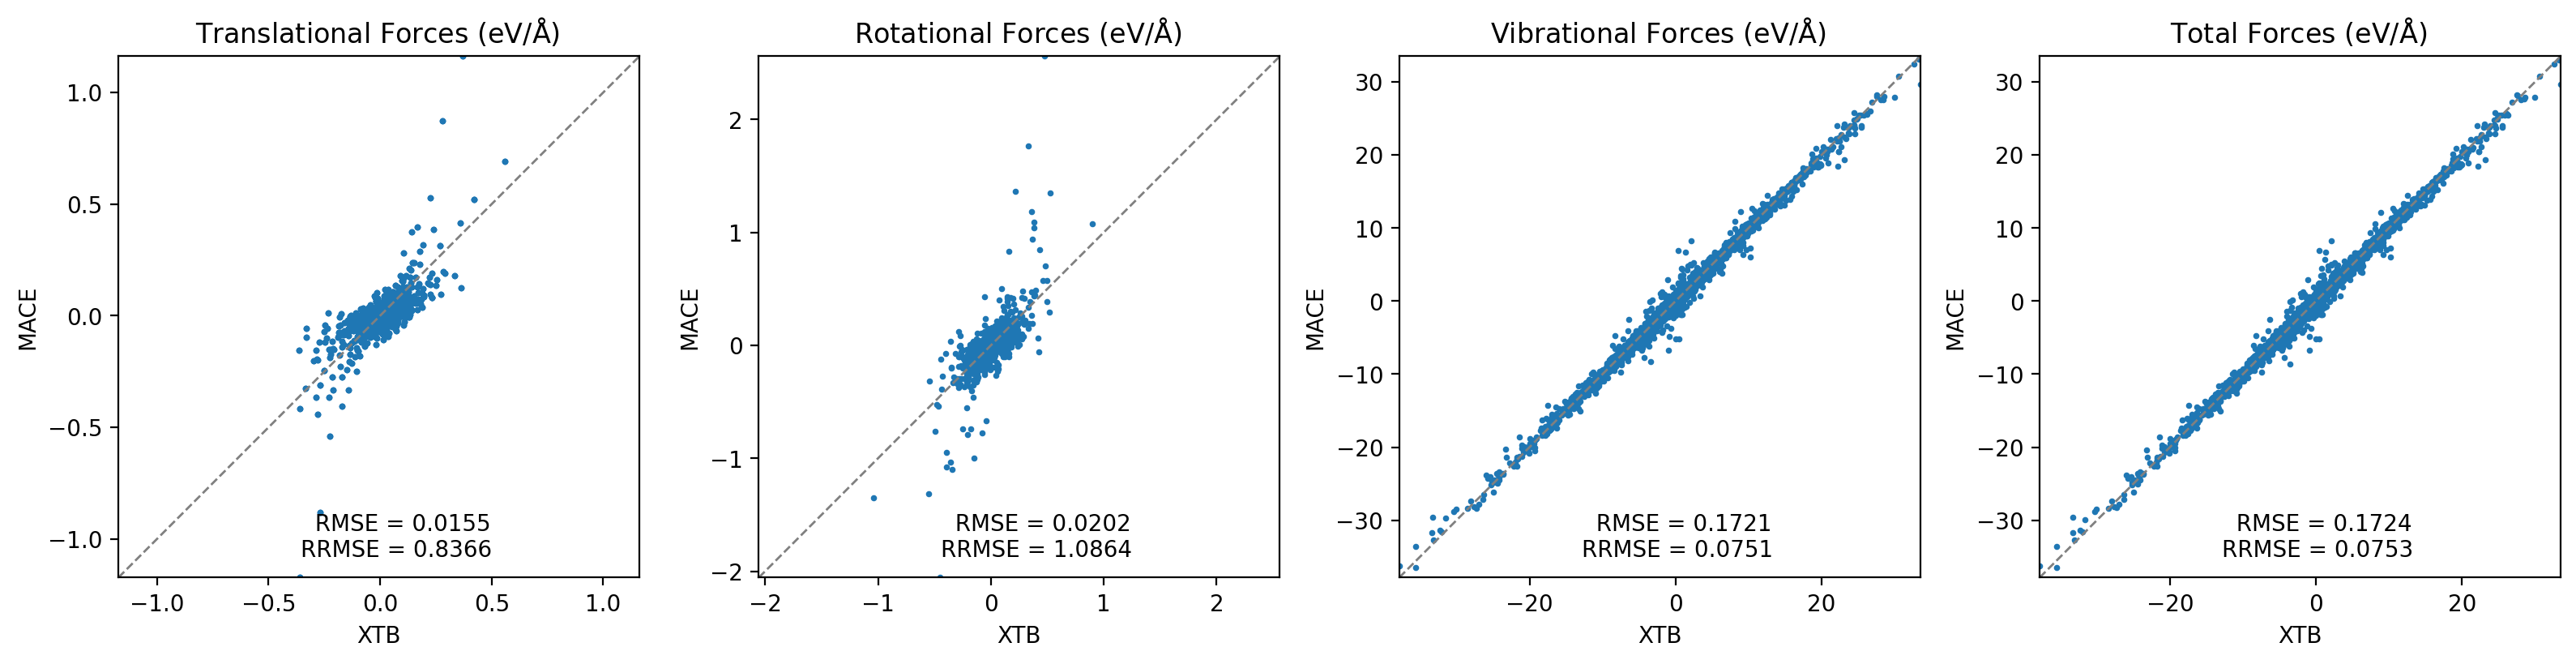

In [24]:
from aseMolec import pltProps as pp
from aseMolec import anaAtoms as aa

db1 = read('tests/mace01/solvent_test.xyz', ':')
ea.rename_prop_tag(db1, 'energy_xtb', 'energy') #Backward compatibility
ea.rename_prop_tag(db1, 'forces_xtb', 'forces') #Backward compatibility

db2 = read('tests/mace01/solvent_test.xyz', ':')
ea.rename_prop_tag(db2, 'MACE_energy', 'energy') #Backward compatibility
ea.rename_prop_tag(db2, 'MACE_forces', 'forces') #Backward compatibility

aa.extract_molecs(db1, intra_inter=True)
aa.extract_molecs(db2, intra_inter=True)

pp.plot_trans_rot_vib(db1, db2, labs=['XTB', 'MACE'])

Indeed, the translation and rotational part of the forces (related to inter-molecular interactions) is significantly harder to capture as evidenced by the larger errors. While the absolute RMSEs are smaller, the relative RMSEs are signifincatly larger for the inter-molecular components. Nevertheless, MACE errors are significantly lower than other models on these tests.

## 4. Molecular Dynamics with MACE

**Let's run your first simulation with MACE in ASE**

### 4.1 Is the dynamics stable?

Accuracy on fixed test sets is great, but molecular dynamics (MD) is the ultimate test. First, we care about stability, then accuracy: let's check if MACE gives stable dynamics. We will start by implementing a simple function to run Langevin dynamics. We initialize the temperature at 300 K and remove all translations and rotations.

In [25]:
from ase.io import read, write
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution

import random
import os
import time
import numpy as np
import pylab as pl
from IPython import display

def simpleMD(init_conf, temp, calc, fname, s, T):
    init_conf.set_calculator(calc)

    #initialize the temperature
    random.seed(701) #just making sure the MD failure is reproducible
    MaxwellBoltzmannDistribution(init_conf, temperature_K=300) #initialize temperature at 300
    Stationary(init_conf)
    ZeroRotation(init_conf)

    dyn = Langevin(init_conf, 1.0*units.fs, temperature_K=temp, friction=0.1) #drive system to desired temperature

    %matplotlib inline

    time_fs = []
    temperature = []
    energies = []

    #remove previously stored trajectory with the same name
    os.system('rm -rfv '+fname)

    fig, ax = pl.subplots(2, 1, figsize=(6,6), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})

    def write_frame():
            dyn.atoms.write(fname, append=True)
            time_fs.append(dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

            ax[0].plot(np.array(time_fs), np.array(energies), color="b")
            ax[0].set_ylabel('E (eV/atom)')

            # plot the temperature of the system as subplots
            ax[1].plot(np.array(time_fs), temperature, color="r")
            ax[1].set_ylabel('T (K)')
            ax[1].set_xlabel('Time (fs)')

            display.clear_output(wait=True)
            display.display(pl.gcf())
            time.sleep(0.01)

    dyn.attach(write_frame, interval=s)
    t0 = time.time()
    dyn.run(T)
    t1 = time.time()
    print("MD finished in {0:.2f} minutes!".format((t1-t0)/60))

Now we can run MD with MACE and compare it to the XTB dynamics. Let's try 2 picoseoncds at 1200 K, starting from a single molecule config:

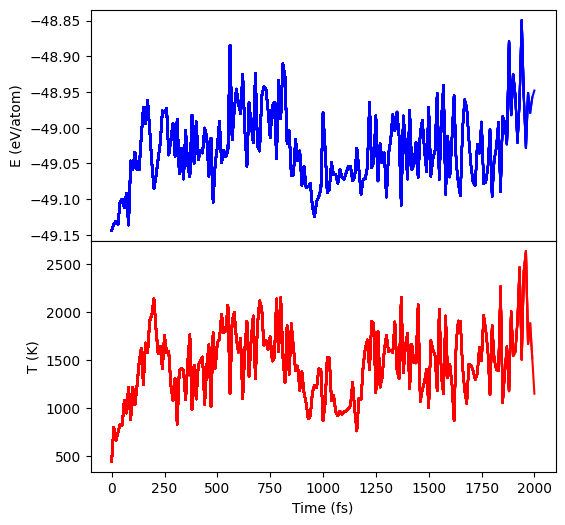

MD finished in 1.50 minutes!


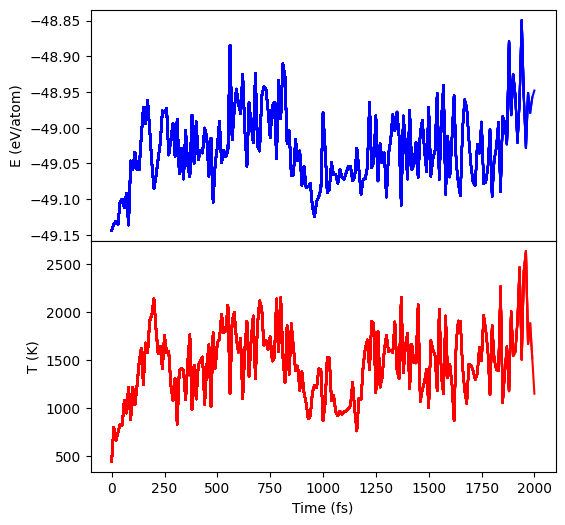

In [26]:
 #let us start with a single molecule
init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()

#we can use MACE as a calculator in ASE!
from mace.calculators import MACECalculator
mace_calc = MACECalculator(model_paths=['MACE_models/mace01_run-123_stagetwo.model'], device='cuda', default_dtype="float32")

simpleMD(init_conf, temp=1200, calc=mace_calc, fname='moldyn/mace01_md.xyz', s=10, T=2000)


In [36]:
%%javascript
fetch('http://127.0.0.1:1234/')
from x3dase.visualize import view_x3d_n
traj = read('moldyn/mace01_md.xyz', index=':')
view_x3d_n(traj)

<IPython.core.display.Javascript object>

For reference, we can also run XTB dynamics from the same starting configuration.

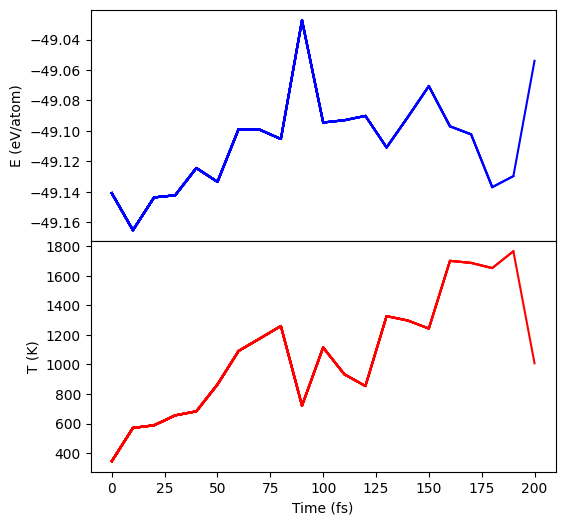

MD finished in 0.09 minutes!


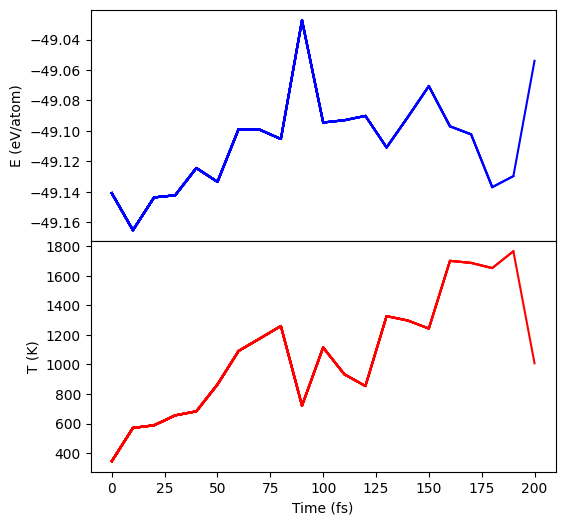

In [31]:
# reinitialize the original config
init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()

from xtb.ase.calculator import XTB
xtb_calc = XTB(method="GFN2-xTB")

simpleMD(init_conf, temp=1200, calc=xtb_calc, fname='moldyn/xtb_md_2.xyz', s=10, T=200)

MACE dynamics finished in under 2 minutes, vs XTB would take over 14, so we stop after just 200 steps. This is the essence of MLIP: speeding up calculations that would otherwise take a long time to run. In this case, the speed-up is just one order of magnitude, but depending on the cost of the reference calculation, it can be many orders of magnitude for expensive Quantum Chemistry methods and large systems. Remember, the cost of MLIP is independent of the accuracy of the potential energy surface!

Let's visualize the trajectory:

In [37]:
from x3dase.visualize import view_x3d_n

traj = read('moldyn/xtb_md_2.xyz', ':')
view_x3d_n(traj)


Obtaining stable dynamics with so little training is a great result. Up until recently, most MLIPs would require a lot of training before MD was stable. MACE combines the lessons learned over 10-15 years in MLIP development, to achieve a smooth and regular potential energy surface, which minimizes the risk of unstable MD.

### 4.2 Is the dynamics accurate?

Are the different dynamics sampling the correct distributions? Let us check the radial distribution functions (RDF). The [aseMolec](https://github.com/imagdau/aseMolec) package provides functionality to do that:

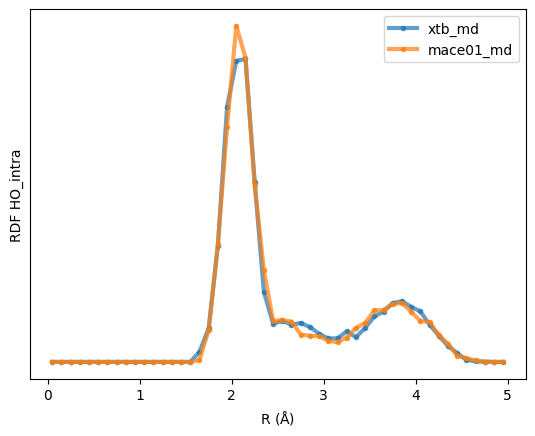

In [33]:
from aseMolec import anaAtoms as aa

tag = 'HO_intra' #choose one of 'HH_intra', 'HC_intra', 'HO_intra', 'CC_intra', 'CO_intra', 'OO_intra'

for f in ['xtb_md', 'mace01_md']:
    traj = read('moldyn/'+f+'.xyz', '50:') #ignore first 50 frames
    for at in traj:
        at.pbc = True #create a fake box for rdf compatibility
        at.cell = [100,100,100]
    rdf = aa.compute_rdfs_traj_avg(traj, rmax=5, nbins=50) #aseMolec provides functionality to compute RDFs
    plt.plot(rdf[1], rdf[0][tag], '.-', label=f, alpha=0.7, linewidth=3)

plt.legend();
plt.yticks([]);
plt.xlabel(r'R ($\rm \AA$)');
plt.ylabel('RDF '+tag);

Try it yourself! Inspect other RDF pairs (`C-O`, `H-C`), how well are they reproduced?

The trajectories here are stable and also quite accurate. This is still a relatively simple task: we chose a single molecule at relatively small temperatures (for a molecule) and only ran for 2 picoseconds. In practice, given enough time and high enough temperature the initial models will fail.

Experiment with the starting configs, temperatures, simulation length, see if you can find problems with the potentials!

### 4.3 MD of a molecular liquid?

The MLIP was trained on clusters, can we simulate the liquid molecular environment?

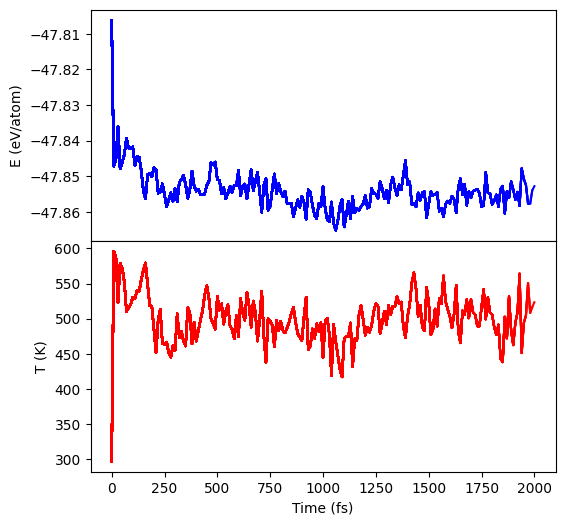

MD finished in 1.46 minutes!


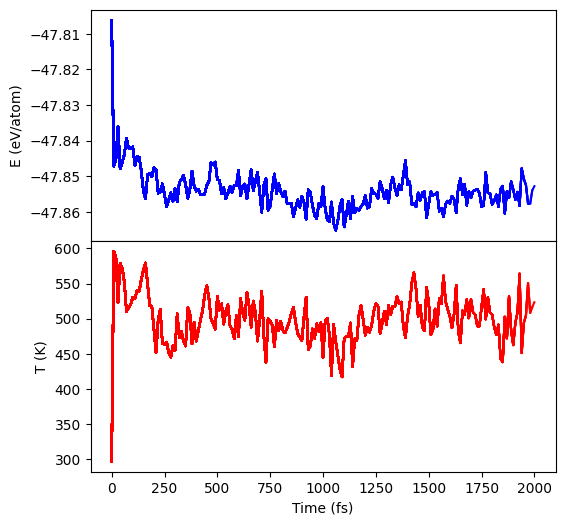

In [34]:
init_conf = read('data/solvent_liquid.xyz') #read a liquid config with periodic boundary conditions
init_conf.center()
simpleMD(init_conf, temp=500, calc=mace_calc, fname='moldyn/mace01_md_liquid.xyz', s=10, T=2000)

This XTB calculator is non-periodic, so this dynamics would not be possible without an MLIP! Check for yourself, by replacing the calculator with `xtb`. The system is much larger than the example before (12 molecules vs just one). Let's view the trajectory:

In [ ]:
from x3dase.visualize import view_x3d_n

traj = read('moldyn/mace01_md_liquid.xyz', ':')
view_x3d_n(traj)

Transferability from clusters to the condensed phase environment is still an [open research](https://doi.org/10.1021/acs.jpcb.2c03746) question. If this works, it implies that we might be able to learn highly accurate Quantum Chemistry PES on molecular clusters and make predictions (density, diffusivity) for the condensed phase! This is new science!